Set up environment

In [2]:
from copy import copy
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import pandas as pd
import seaborn as sns
sns.set_style("white")

In [3]:
import sys
sys.path.append('/Users/zeynepenkavi/Dropbox/RangelLab/NeuralMassModels/helpers')
from make_network import default_args, generateStructuralNetwork, generateSynapticNetwork, networkModel
from eGLM_helpers import phi, make_stimtimes
from multregconn import multregconn
from get_pearson_fc_wci import get_pearson_fc_wci
from get_multreg_fc_wci import get_multreg_fc_wci

Importing eGLM helpers...
All eGLM helpers imported!


# Make network

In [4]:
num_sims = 20
networks = np.ndarray(num_sims, dtype=object)

In [5]:
for i in range(num_sims):
    sim_args = copy(default_args)
    sim_args.update({'hubnetwork_dsity': .5,
                'outnetwork_dsity':.3, 
                'innetwork_dsity': .60,})
    W = generateSynapticNetwork(generateStructuralNetwork(sim_args), sim_args)
    sim_args.update({'W': W,
                'noise': 1, 
                'noise_scale': 1,
                'Tmax': 3000})
    networks[i] = sim_args

Plot some sample networks

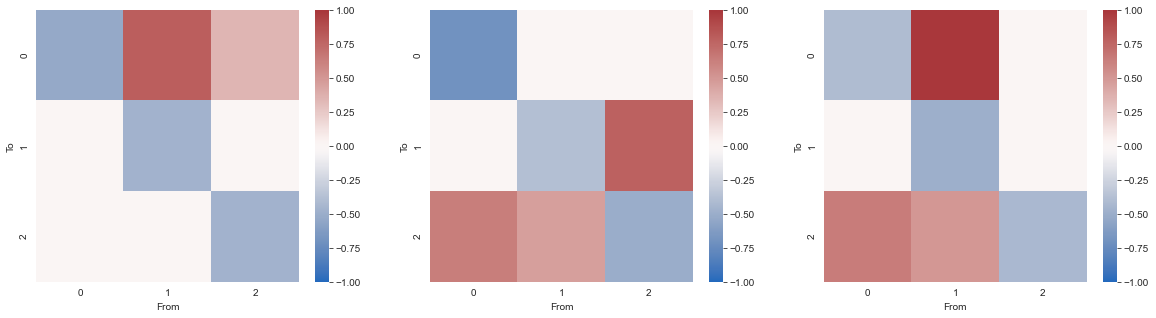

In [6]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 5
fig, a = plt.subplots(1, 3)

for i,j in enumerate([3,5,8]):
    sns.heatmap(networks[j]['W'], ax=a[i], vmin=-1, vmax=1, cmap="vlag")
    a[i].set_xlabel('From')
    a[i].set_ylabel('To')

# Generate resting-state time series

Resting data in this case is only noise not an AR(1) process.

In [7]:
rest_data = np.ndarray(num_sims, dtype=object)

for i in range(num_sims):
    sim_args = networks[i]
    rest_data[i], _ = networkModel(sim_args['W'], args_dict=sim_args)

# Compute FC connectivity matrices

## Pearson

### Lag 0

In [8]:
pearson_fcs = np.ndarray(num_sims, dtype=object)
pearson_fcs_lb = np.ndarray(num_sims, dtype=object)
pearson_fcs_ub = np.ndarray(num_sims, dtype=object)
pearson_fcs_rmse = np.ndarray(num_sims, dtype=object)

for i, cur_data in enumerate(rest_data):
    pearson_fcs[i], pearson_fcs_lb[i], pearson_fcs_ub[i], pearson_fcs_rmse[i] = get_pearson_fc_wci(cur_data, networks[i])

### Lag 1

In [9]:
lag_pearson_fcs = np.ndarray(num_sims, dtype=object)
lag_pearson_fcs_lb = np.ndarray(num_sims, dtype=object)
lag_pearson_fcs_ub = np.ndarray(num_sims, dtype=object)
lag_pearson_fcs_rmse = np.ndarray(num_sims, dtype=object)

for i, cur_data in enumerate(rest_data):
    lag_pearson_fcs[i], lag_pearson_fcs_lb[i], lag_pearson_fcs_ub[i], lag_pearson_fcs_rmse[i] = get_pearson_fc_wci(cur_data, networks[i], lag = 1)

## Multiple regression

FC estimated by using the [multiple regression used by Cole et al.](https://github.com/ColeLab/ActflowToolbox/blob/master/connectivity_estimation/multregconn.py) expanded to add confidence intervals and rmse [here](https://github.com/zenkavi/NeuralMassModels/blob/master/helpers/multregconn.py).

### Lag = 0

In [10]:
mreg_fcs = np.ndarray(num_sims, dtype=object)
mreg_fcs_lb = np.ndarray(num_sims, dtype=object)
mreg_fcs_ub = np.ndarray(num_sims, dtype=object)
mreg_fcs_rmse = np.ndarray(num_sims, dtype=object)

for i, cur_data in enumerate(rest_data):
    mreg_fcs[i], mreg_fcs_lb[i], mreg_fcs_ub[i], mreg_fcs_rmse[i] = get_multreg_fc_wci(cur_data, networks[i])

### Lag = 1

In [11]:
lag_mreg_fcs = np.ndarray(num_sims, dtype=object)
lag_mreg_fcs_lb = np.ndarray(num_sims, dtype=object)
lag_mreg_fcs_ub = np.ndarray(num_sims, dtype=object)
lag_mreg_fcs_rmse = np.ndarray(num_sims, dtype=object)

for i, cur_data in enumerate(rest_data):
    lag_mreg_fcs[i], lag_mreg_fcs_lb[i], lag_mreg_fcs_ub[i], lag_mreg_fcs_rmse[i] = get_multreg_fc_wci(cur_data, networks[i], lag=1)

# Summarise results

## RMSE of recovered FC matrices

Text(0.5, 1.0, 'MReg lag = 1')

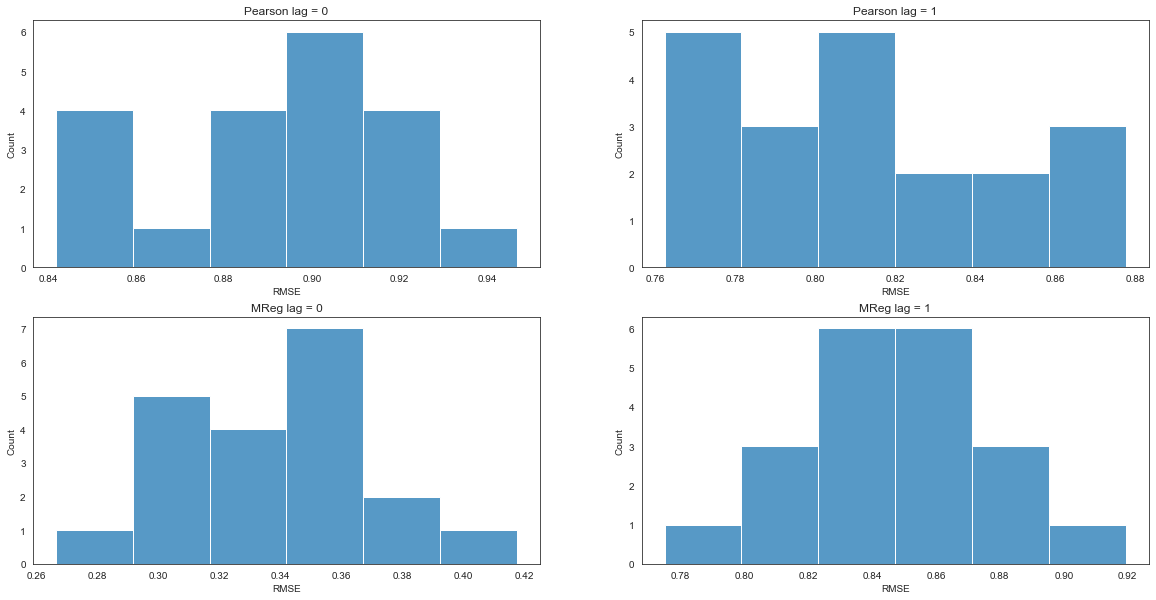

In [12]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 10
fig, a = plt.subplots(2, 2)

rmses = [pearson_fcs_rmse, lag_pearson_fcs_rmse, mreg_fcs_rmse, lag_mreg_fcs_rmse]

for i, cur_rmse in enumerate(rmses):
    sns.histplot(cur_rmse, ax = a.flatten()[i])
    a.flatten()[i].set_xlabel("RMSE")
    
a.flatten()[0].set_title("Pearson lag = 0")
a.flatten()[1].set_title("Pearson lag = 1")
a.flatten()[2].set_title("MReg lag = 0")
a.flatten()[3].set_title("MReg lag = 1")

## True vs. predicted connectivity values

Text(0.5, 1.0, 'MReg lag = 1')

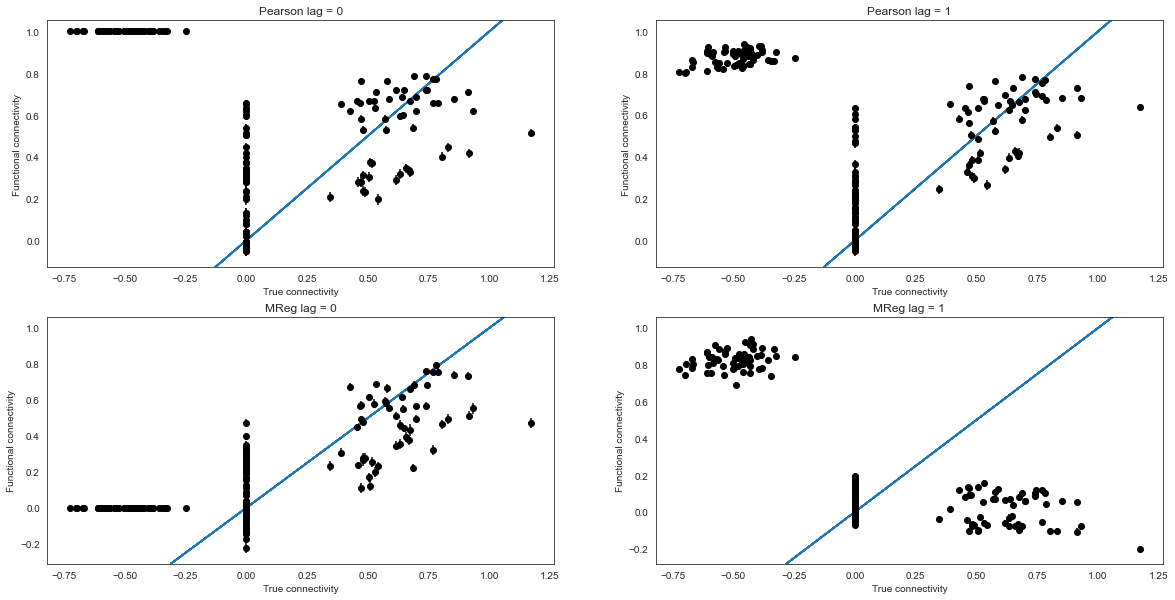

In [13]:
plt.rcParams["figure.figsize"][0] = 20
plt.rcParams["figure.figsize"][1] = 10
fig, a = plt.subplots(2, 2)

fcs = [pearson_fcs, lag_pearson_fcs, mreg_fcs, lag_mreg_fcs]
lbs = [pearson_fcs_lb, lag_pearson_fcs_lb, mreg_fcs_lb, lag_mreg_fcs_lb]
ubs = [pearson_fcs_ub, lag_pearson_fcs_ub, mreg_fcs_ub, lag_mreg_fcs_ub]


for i in range(len(fcs)):
    for j in range(num_sims):
        le = fcs[i][j] - lbs[i][j]
        ue = ubs[i][j] - fcs[i][j]
        a.flatten()[i].errorbar(x = networks[j]['W'].flatten(), y = fcs[i][j].flatten(), yerr = np.array([le.flatten(), ue.flatten()]), fmt='o', color="black")
        a.flatten()[i].set_xlabel("True connectivity")
        a.flatten()[i].set_ylabel("Functional connectivity")
        a.flatten()[i].axline([0, 0], [1, 1])
    
a.flatten()[0].set_title("Pearson lag = 0")
a.flatten()[1].set_title("Pearson lag = 1")
a.flatten()[2].set_title("MReg lag = 0")
a.flatten()[3].set_title("MReg lag = 1")

## Conclusions

- None is sensitive to inhibitory self connections
- None is selective to correctly estimate lack of connections
- For all non-inhibitory connections there is bias towards underestimation in all methods



Are our findings surprising?

Here's the recovery success of the true connectivity using resting-state FC from Cole et al. (2016)

<img src="ColeEtAl_2016_FCRecovery.png">

Here's the recovery success of the true connectivity using resting-state FC from Ito et al. (2017)

<img src="ItoEtAl_2017_FCRecovery.png">

- Their simulated networks do not have inhibitory simulations
- The recovered values are very different than true values and consistently underestimating 

Does activity flow mapping consistently underestimate activation values (since the connectivity estimates are lower than true values)?

Can we improve on activity flow mapping with directed connectivity estimates from resting state?